In [36]:
# Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import ttest_ind

In [37]:
# Dependencies cont'd
import datetime as dt

In [38]:
# Dependencies cont'd
import sqlalchemy
from sqlalchemy import create_engine
# Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
con = engine.connect()

Text(0, 0.5, 'Inches')

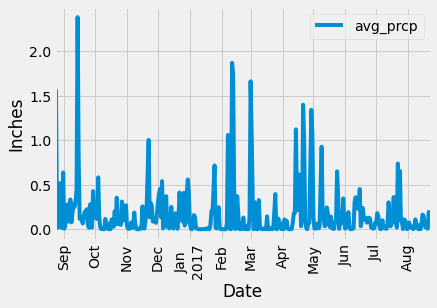

In [39]:
# Create a query to retrieve last 12 months of percipitation data and plot results
query = f'''
    SELECT
        date,
        AVG(prcp) as avg_prcp
    FROM
        measurement
    WHERE
        date >= (SELECT DATE(MAX(date), '-1 year') FROM measurement)
    GROUP BY
        date
    ORDER BY
        date
'''

# Save query results as pandas dataframe, set index as date column
prcp_df = pd.read_sql(query, con)
prcp_df['date'] = pd.to_datetime(prcp_df['date'])

# Set index, and sort dataframe
prcp_df.set_index('date', inplace=True)

# Plot the data through Matplotlib within Pandas library
prcp_df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')

In [45]:
# Summary statistics for dataframe
prcp_df.describe()

,avg_prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [46]:
# Create a query to show the count of stations
query = '''
    SELECT
        COUNT(*) AS station_count
    FROM
        station
'''

station_df = pd.read_sql(query, con)
station_count = station_df['station_count'].values[0]
print(f'There is {station_count} stations in the database.')

There is 9 stations in the database.


In [50]:
# Create a query to distinguish the most active stations
query = '''
    SELECT
        s.station,
        s.name,
        COUNT(*) AS station_count
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    GROUP BY
        s.station,
        s.name
    ORDER BY
        station_count DESC
'''

activestation_df = pd.read_sql(query, con)
activestation_df

,station,name,station_count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [56]:
# Calculate the lowest and highest temps. recorded, and the average
# temperature of the most active station
activestation_df.sort_values('station_count', ascending=False, inplace=True)
most_active = activestation_df['station'].values[0]

query = f'''
    SELECT
        MIN(tobs) AS min_tobs,
        MAX(tobs) AS max_tobs,
        AVG(tobs) AS avg_tobs
    FROM
        measurement
    WHERE
        station = '{most_active}'
'''

temp_df = pd.read_sql(query, con)
temp_df

,min_tobs,max_tobs,avg_tobs
0,54.0,85.0,71.663781


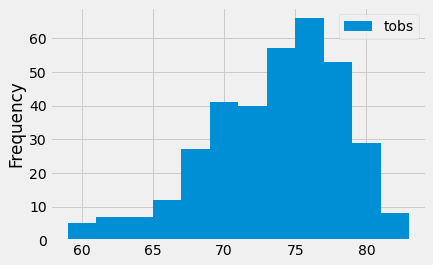

In [58]:
# Create a query for the last 12 months of temperature observation data
# for the station with the highest number of temp. observations and plot
# the results
query = f'''
    SELECT
        tobs
    FROM
        measurement
    WHERE
        date >= (SELECT DATE(MAX(date), '-1 year') FROM measurement)
        AND
        station = '{most_active}'
'''

temp_df = pd.read_sql(query, con)
temp_df.plot.hist(bins=12)

In [60]:
## DATA ANALYSIS SECTION

In [63]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    query = f'''
            SELECT
            MIN(tobs) AS min_tobs,
            MAX(tobs) AS max_tobs,
            AVG(tobs) AS avg_tobs
        FROM
            measurement
        WHERE
            date BETWEEN '{start_date}' AND '{end_date}'
    '''
    
    temp_stat_df = pd.read_sql(query, con)
    temp_stat = tuple(temp_stat_df.values[0])
    
    return temp_stat

# Function usage example
print(calc_temps('2017-01-01', '2017-12-31'))

(58.0, 87.0, 74.14387974230493)


In [64]:
# Use the previous function 'calc_temps' to calculate the tmin, tavg,
# and tmax for your trip using the previous year's data
mytrip_temps = calc_temps('2013-07-06', '2013-07-13')
mytrip_temps

(70.0, 82.0, 75.62711864406779)

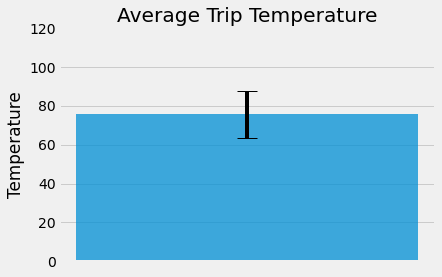

In [74]:
# Plot the results from your previous query as a bar chart
y = mytrip_temps[2]
yerr = mytrip_temps[1] - mytrip_temps[0]
x_pos = 1

fig, ax = plt.subplots()
ax.bar(x_pos, y, yerr=yerr, align='center', alpha=0.75, ecolor='black', capsize=10)
ax.set_ylabel('Temperature')
ax.set_xticks([0])
ax.set_title("Average Trip Temperature")
ax.set_ylim(0,120)
ax.yaxis.grid(True)

In [77]:
# Calculate the total amount of rainfall per weather station for your trip
# dates using the previous year's matching dates.
query = f'''
    SELECT
        s.station AS station,
        s.name AS station_name,
        s.latitude,
        s.longitude,
        s.elevation,
        SUM(prcp) AS 'total rainfall'
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    WHERE
        date BETWEEN '2013-07-06' AND '2013-07-13'
    GROUP BY
        s.station
    ORDER BY
        SUM(prcp) DESC
'''

total_rainfall = pd.read_sql(query, con)
total_rainfall

,station,station_name,latitude,longitude,elevation,total rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.15
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.40
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.34
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.30
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.17
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.04
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.00


In [84]:
# Create a query that will calculate the daily normals
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    """
    
    query = f'''
        SELECT
            MIN(tobs) AS min_tobs,
            MAX(tobs) AS max_tobs,
            AVG(tobs) AS avg_tobs
        FROM
            measurement
        WHERE
            date LIKE '%-{date}'
    '''
    
    dailytemp_df = pd.read_sql(query, con)
    dailytemp = tuple(dailytemp_df.values[0])
    
    return dailytemp

print(daily_normals("01-02"))

(60.0, 77.0, 69.39622641509433)


In [86]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = '2013-07-06'
end_date = '2013-07-13'

# Use the start and end date to create a range of dates
vacay = pd.date_range(start=start_date, end=end_date)

# Stip off the year and save a list of %m-%d strings
realvacay = vacay.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for days in realvacay:
    normals.append(daily_normals(days))
normals

[(69.0, 81.0, 75.0),
 (69.0, 82.0, 74.91071428571429),
 (69.0, 83.0, 76.08333333333333),
 (68.0, 83.0, 76.19298245614036),
 (68.0, 82.0, 75.62068965517241),
 (70.0, 81.0, 75.78947368421052),
 (67.0, 82.0, 75.96491228070175),
 (69.0, 81.0, 76.1896551724138)]

In [87]:
# Load the previous query results into a Pandas DataFrame and add the
# `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tmax', 'tavg'])
df['date'] = vacay
df.set_index('date', inplace=True)
df

,tmin,tmax,tavg
date,,,
2013-07-06,69.0,81.0,75.000000
2013-07-07,69.0,82.0,74.910714
2013-07-08,69.0,83.0,76.083333
2013-07-09,68.0,83.0,76.192982
2013-07-10,68.0,82.0,75.620690
2013-07-11,70.0,81.0,75.789474
2013-07-12,67.0,82.0,75.964912
2013-07-13,69.0,81.0,76.189655


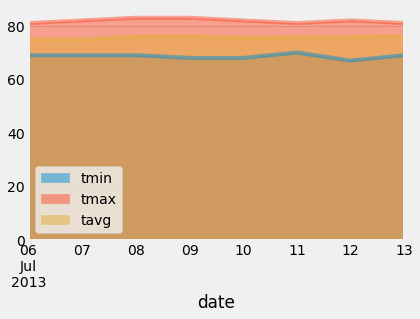

In [88]:
# Plot the daily normals as an area plot
df.plot(kind='area', stacked=False)